<a href="https://colab.research.google.com/github/ahmed-hesham1221/CV-Project-QR-/blob/main/Final_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install --upgrade reedsolo
import reedsolo as rs
from reedsolo import RSCodec, ReedSolomonError
from google.colab.patches import cv2_imshow
from scipy.signal import convolve2d


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_images_from_folder(folder_path):
    # Get a sorted list of files in the given folder
    file_list = sorted(os.listdir(folder_path))
    # Initialize an empty list to store the images
    images = []
    for filename in file_list:
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)

            # Read the image in grayscale
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
        return images

In [5]:
folder_path = '/content/drive/MyDrive/CV_Project/Test_Cases'
images = load_images_from_folder(folder_path)


In [7]:
def display_image(img, title='IMG', figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [51]:
import cv2
import numpy as np

def is_image_blurry(image, threshold=100.0):
    """
        if variance greater than 4 then the image is Number 11
        else image number 9
    """
    if image is None:
        raise ValueError("The provided image is invalid.")

    # Compute the Laplacian of the image and then the variance
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    variance_of_laplacian = laplacian.var()

    # Determine if the image is blurry
    is_blurry = variance_of_laplacian < threshold
    return is_blurry, variance_of_laplacian



# Check if each image is blurry
image1_blurry, image1_variance = is_image_blurry(images[8])
image2_blurry, image2_variance = is_image_blurry(images[10])

# Print the results
print(f"Image 1 is {'blurry' if image1_blurry else 'not blurry'} with a variance of {image1_variance}.")
print(f"Image 2 is {'blurry' if image2_blurry else 'not blurry'} with a variance of {image2_variance}.")




Image 1 is blurry with a variance of 2.185901658334999.
Image 2 is blurry with a variance of 8.590675298131211.


In [51]:
for img in images:

  if is_image_blurry(img):
    if



In [42]:


def check_qr_alignment(image, angle_threshold=5):
    # Convert to grayscale if needed
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Threshold to get a binary image
    _, binary = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Extract and adjust angles from contours
    angles = [(cv2.minAreaRect(cnt)[2] + 90) if cv2.minAreaRect(cnt)[2] < -45 else cv2.minAreaRect(cnt)[2] for cnt in contours]

    if not angles:
        print("No contours found.")
        return False

    # Find the most common angle
    most_common_angle = max(set(angles), key=angles.count)
    print(f"The most common angle among contours is: {most_common_angle:.2f} degrees")

    # Return True if the most common angle is approximately 90 degrees
    return abs(most_common_angle - 90) <= angle_threshold



In [45]:
is_aligned = check_qr_alignment(images[5])
print(f"Is the QR code aligned: {is_aligned}")

The most common angle among contours is: 18.70 degrees
Is the QR code aligned: False


Found 3 potential locator squares.


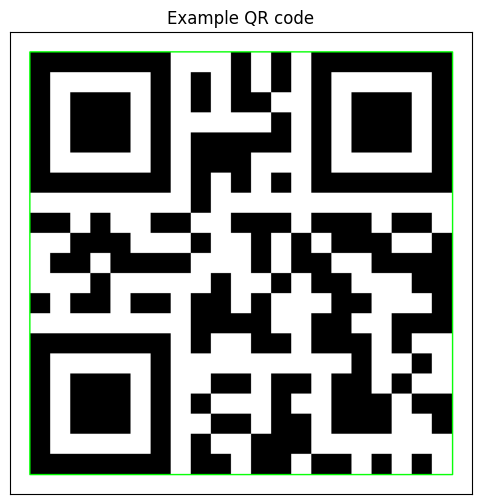

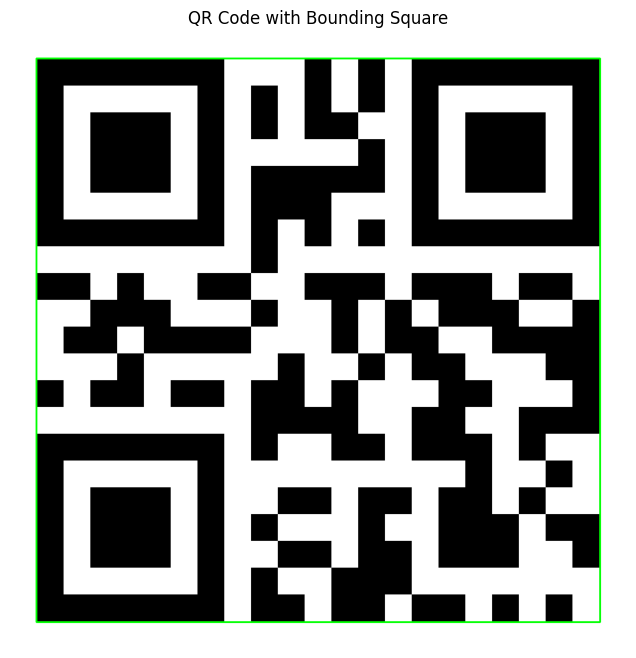

In [52]:

def find_qr_locator_squares(image):
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply a simple binary threshold
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Find contours and hierarchy
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if hierarchy is None:
        return []

    hierarchy = hierarchy[0]
    locator_squares = []

    for idx, contour in enumerate(contours):
        # Check if the contour has a child (it is a parent)
        child_idx = hierarchy[idx][2]
        if child_idx != -1:
            # Check if the child has a child (it is a grandparent)
            grandchild_idx = hierarchy[child_idx][2]
            if grandchild_idx != -1:
                peri = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

                if len(approx) == 4:  # Contour has 4 vertices, potentially a square
                    (x, y, w, h) = cv2.boundingRect(approx)
                    aspect_ratio = w / float(h)
                    if 0.9 <= aspect_ratio <= 1.1:  # Aspect ratio check for squareness
                        if 100 < w < 800:  # Adjust size check for smaller 21x21 QR codes
                            locator_squares.append((x, y, w, h))

    return locator_squares

def draw_bounding_square(image, locator_squares):
    if len(locator_squares) < 3:
        print("Less than 3 locator squares found")
        return image

    # Sort the locator squares by their positions
    locator_squares = sorted(locator_squares, key=lambda s: (s[1], s[0]))

    # Consider only the three main locator squares
    top_left = locator_squares[0]
    bottom_left = locator_squares[1]
    top_right = locator_squares[2]

    # Find the outermost coordinates
    min_x = min(top_left[0], bottom_left[0], top_right[0])
    min_y = min(top_left[1], bottom_left[1], top_right[1])
    max_x = max(top_left[0] + top_left[2], bottom_left[0] + bottom_left[2], top_right[0] + top_right[2])
    max_y = max(top_left[1] + top_left[3], bottom_left[1] + bottom_left[3], top_right[1] + top_right[3])

    # Draw the bounding rectangle around the three main locator squares
    cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

    return image

img=images[0]


locator_squares = find_qr_locator_squares(img)
print("Found {} potential locator squares.".format(len(locator_squares)))

# Convert grayscale image to BGR for color display
img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw bounding boxes around each detected locator square
bounded_img = draw_bounding_square(img_bgr, locator_squares)

# Display the result
fig = plt.figure(figsize=(6, 6))
plt.xticks([], [])
plt.yticks([], [])
plt.title('Example QR code')
plt.imshow(cv2.cvtColor(bounded_img, cv2.COLOR_BGR2RGB))
plt.show()

# Draw bounding square (already drawn in img_bgr)
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(bounded_img, cv2.COLOR_BGR2RGB))
plt.title('QR Code with Bounding Square')
plt.axis('off')
plt.show()


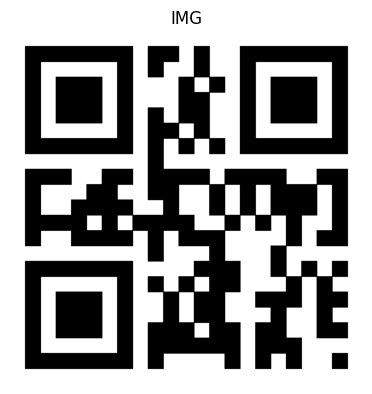

In [11]:

def Black_M(images, index=3):
    # Select the image at the specified index
    img = images[index]
    gray = cv2.flip(img, 1)
    threshold = 0
    mask = gray <= threshold
    gray[mask] = 255
    kernel = np.ones((5, 5), np.uint8)
    dilated_image = cv2.dilate(gray, kernel, iterations=3)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=3)
    enhanced_image = cv2.convertScaleAbs(eroded_image)
    img = enhanced_image
    display_image(img)



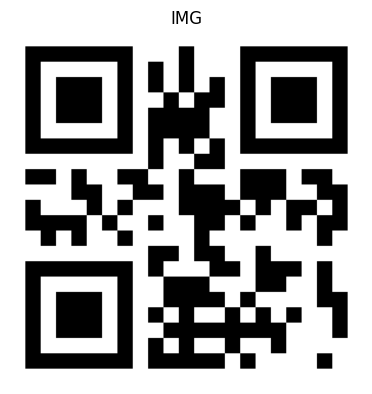

In [10]:
def Leffy(images, index=2):
    img = images[index]
    flipped_vertically = cv2.flip(img, 0)
    flipped_both = cv2.flip(flipped_vertically, 1)
    img = flipped_both
    display_image(img)




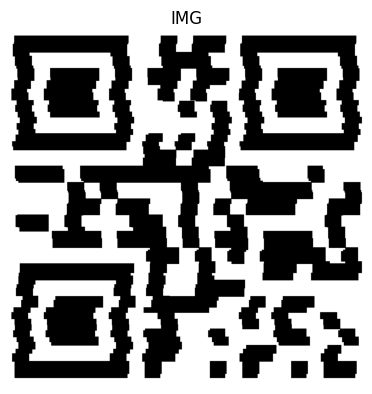

In [14]:
def remove_haze(hazy_image, kernel_size=(7, 7), iterations=5):
    # Convert the image to 8-bit grayscale if necessary
    if hazy_image.dtype != np.uint8:
        hazy_image = cv2.convertScaleAbs(hazy_image)

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(hazy_image)

    # Apply binary thresholding
    threshold_value = 150
    binary_image = np.array(cv2.threshold(equalized_image, 254, 255, cv2.THRESH_BINARY)[1], dtype="uint8")

    # Apply median filtering
    kernel_size = 9
    median_filtered = cv2.medianBlur(binary_image, kernel_size)

    # Apply morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Define the kernel for dilation
    square_size = 14
    dilation_kernel = np.ones((square_size, square_size), np.uint8)

    # Apply morphological dilation to make the black squares more square-shaped
    dilated_img = cv2.dilate(equalized_image, dilation_kernel, iterations=1)

    # Apply erosion
    erosion_kernel = np.ones((15, 15), np.uint8)
    eroded_img = cv2.erode(dilated_img, erosion_kernel, iterations=1)

    return eroded_img

def ceaser(images, index=4):
    # Select the image at the specified index
    img = images[index]

    # Remove haze from the image
    img = remove_haze(img)

    display_image(img)




Image loaded successfully.


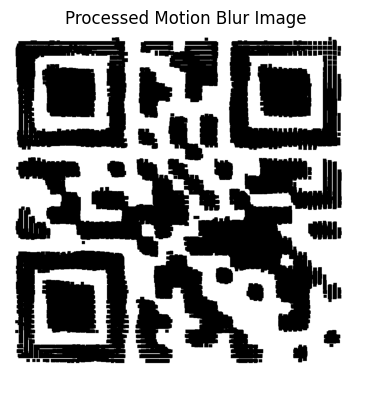

In [25]:
def my_phone(images, index=8):
    img = images[index]
    if img is None:
        print("Error: Unable to read image.")
    else:
        print("Image loaded successfully.")

        def motion_kernel(angle, length):
            """Creates a motion blur kernel."""
            kernel = np.zeros((length, length))
            kernel[int((length - 1) / 2), :] = np.ones(length)
            M = cv2.getRotationMatrix2D((length // 2, length // 2), angle, 1)
            kernel = cv2.warpAffine(kernel, M, (length, length))
            kernel /= np.sum(kernel)
            return kernel

        def wiener_deconvolution(image, psf, noise_var):
            """Performs Wiener deconvolution."""
            image_dft = np.fft.fft2(image)
            psf_dft = np.fft.fft2(psf, s=image.shape)
            psf_dft_conj = np.conj(psf_dft)
            psf_dft_mag_squared = np.abs(psf_dft) ** 2
            wiener_filter = psf_dft_conj / (psf_dft_mag_squared + noise_var)
            restored_dft = image_dft * wiener_filter
            restored_image = np.fft.ifft2(restored_dft)
            return np.abs(restored_image)

        # Define the angle and length of the motion blur
        angle = 315  # Adjust the angle as needed (in degrees)
        length = 20  # Adjust the length of the motion blur as needed

        # Create the motion blur kernel
        psf = motion_kernel(angle, length)

        # Define the noise variance (adjust as needed)
        noise_variance = 1e-4

        # Perform Wiener deconvolution
        restored_image = wiener_deconvolution(img, psf, noise_variance)

        # Convert the image to an 8-bit unsigned integer depth
        restored_image = cv2.convertScaleAbs(restored_image)

        # Apply a threshold to the gradient image to create a binary image
        threshold_value = 150
        binary_image = np.array(cv2.threshold(restored_image, threshold_value, 255, cv2.THRESH_BINARY)[1], dtype="uint8")

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
        closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

        kernel_size2 = (12, 12)  # You can adjust the kernel size as needed
        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size2)
        eroded_image = cv2.erode(closed_image, kernel2, iterations=1)

        kernel_size3 = (1, 1)  # You can adjust the kernel size as needed
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size3)
        dilated_image = cv2.dilate(closed_image, kernel3, iterations=1)

        img = dilated_image

        # Display the resulting image
        display_image(img, title='Processed Motion Blur Image')



#

Image loaded successfully.


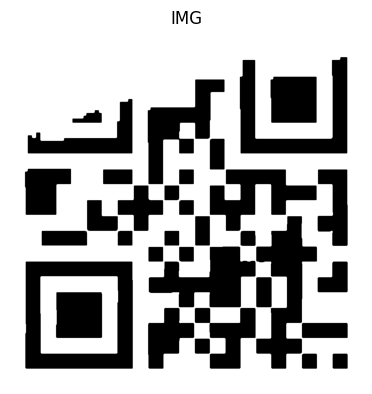

In [16]:

def process_image(image):
    if image is None:
        print("Error: Unable to read image.")
        return None
    else:
        print("Image loaded successfully.")

        # Check the image data type
        if image.dtype != np.uint8:
            # Convert the image to 8-bit grayscale
            image = cv2.convertScaleAbs(image)

        # Apply histogram equalization
        equalized_image = cv2.equalizeHist(image)

        # Apply binary thresholding
        threshold_value = 150
        binary_image = np.array(cv2.threshold(equalized_image, 254, 255, cv2.THRESH_BINARY)[1], dtype="uint8")

        # Apply median filtering with a kernel size of 7x7
        kernel_size = 7
        median_filtered = cv2.medianBlur(binary_image, kernel_size)

        # Apply morphological operations (e.g., closing) to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

        # Define the kernel for dilation
        square_size = 12
        dilation_kernel = np.ones((square_size, square_size), np.uint8)

        # Apply morphological dilation to make the black squares more square-shaped
        dilated_img = cv2.dilate(equalized_image, dilation_kernel, iterations=1)

        # Apply erosion with a 10x10 pixel square filter
        erosion_kernel = np.ones((10, 10), np.uint8)
        eroded_img = cv2.erode(dilated_img, erosion_kernel, iterations=1)

        # Apply average filtering
        avg_filtered_img = cv2.blur(eroded_img, (5, 5))

        # Apply binary thresholding to the averaged image
        _, binary_roi = cv2.threshold(avg_filtered_img, 145, 255, cv2.THRESH_BINARY)

        return binary_roi

def Gone(images, index=9):

    img = images[index]
    processed_img = process_image(img)

    display_image(processed_img)




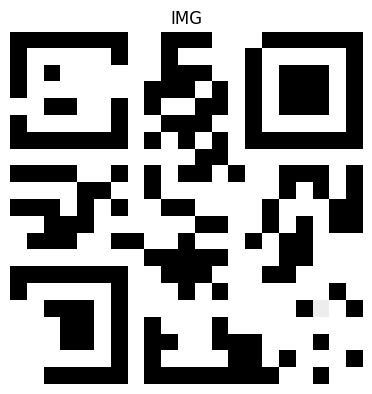

In [17]:

def remove_black_areas(image, threshold=150, off_white_threshold=1):

    # Check if the image is already grayscale
    if len(image.shape) == 2 or image.shape[2] == 1:
        gray = image  # Image is already grayscale
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to identify black areas
    _, thresholded = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Invert the thresholded image to get black areas as white
    thresholded = cv2.bitwise_not(thresholded)

    # Apply bitwise AND to keep black regions
    if len(image.shape) == 2 or image.shape[2] == 1:
        # If the input is grayscale, stack channels to create a 3-channel image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    result = cv2.bitwise_and(image, image, mask=thresholded)

    # Create a mask for off-white areas
    off_white_mask = cv2.inRange(gray, off_white_threshold, 255)

    # Set off-white areas to white (255) in the result image
    result[off_white_mask != 0] = [255, 255, 255]

    # Convert the result back to grayscale
    result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    return result

def Noor(images, index=12, threshold=150, off_white_threshold=1, start_row=50, end_row=962, start_col=50, end_col=962, resize_dim=(21, 21)):

    img = images[index]

    # Remove black areas and set off-white areas to white
    img = remove_black_areas(img, threshold, off_white_threshold)

    # Apply average filter
    avg_filtered_img = cv2.blur(img, (5, 5))

    # Crop the region of interest
    avg_filtered_img = avg_filtered_img[start_row:end_row, start_col:end_col]

    # Convert the resized ROI to binary black and white using thresholding
    _, binary_roi = cv2.threshold(avg_filtered_img, 140, 255, cv2.THRESH_BINARY)

    # Resize the image
    img = cv2.resize(binary_roi, resize_dim, cv2.INTER_NEAREST)
    display_image(img)



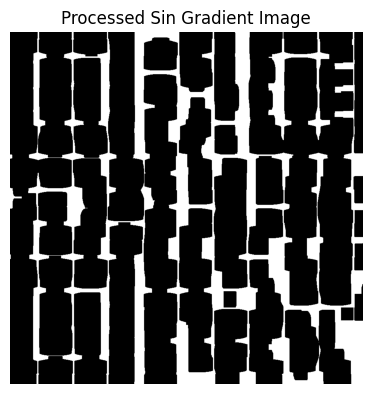

In [26]:
def remove_sin_gradient(img):
    # Apply Fourier Transform
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # Identify the frequency corresponding to the sinusoidal noise
    frequency = (11 / img.shape[1]) * 1.5  # Assuming the noise has 11 complete cycles

    # Create a filter mask
    filter_mask = np.ones_like(f_transform_shifted)
    rows, cols = filter_mask.shape
    for i in range(rows):
        for j in range(cols):
            # Calculate the distance from the center
            dist = np.sqrt((i - rows / 2) ** 2 + (j - cols / 2) ** 2)
            # If the frequency is within a certain range, set the mask value to 0
            if abs(dist - frequency * rows) < 1:  # Adjust the range as needed
                filter_mask[i, j] = 0

    # Apply the filter mask
    filtered_transform = f_transform_shifted * filter_mask

    # Perform inverse Fourier Transform
    filtered_img = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_transform)))

    # Apply thresholding
    _, thresh_img = cv2.threshold(filtered_img, 89, 255, cv2.THRESH_BINARY)

    # Perform dilation operation
    dilation_size = 1  # Change this value as needed
    kernel_dilation = np.ones((dilation_size, dilation_size), np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel_dilation, iterations=1)

    # Define the size of the rectangle for erosion
    erosion_height = 32
    erosion_width = 32

    # Create a kernel for erosion
    kernel_erosion = np.ones((erosion_height, erosion_width), np.uint8)

    # Perform erosion operation
    eroded_img = cv2.erode(dilated_img, kernel_erosion, iterations=1)

    # Define cropping dimensions
    top_crop = 40
    bottom_crop = 40
    left_crop = 40
    right_crop = 40

    # Perform cropping
    cropped_img = eroded_img[top_crop:-bottom_crop, left_crop:-right_crop]

    return cv2.convertScaleAbs(cropped_img)

def Sine_stu(images, index=10):
    img = remove_sin_gradient(images[index])
    display_image(img, title='Processed Sin Gradient Image')




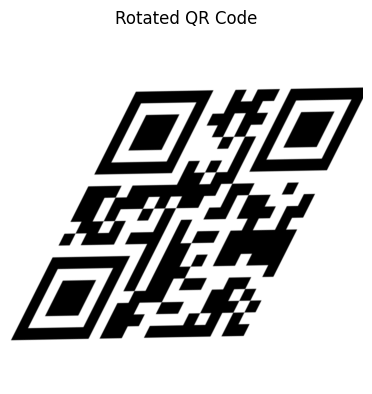

In [22]:
def Railfance(images, index=5):
    img = images[index]

    # Threshold the image to get a binary image
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and find the largest contour (the QR code)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

    qr_corners = None  # Initialize qr_corners

    for contour in contours:
        # Approximate the contour to get the four corners of the QR code
        for epsilon in np.arange(0.01, 0.2, 0.01):  # Try different epsilon values
            approx = cv2.approxPolyDP(contour, epsilon * cv2.arcLength(contour, True), True)
            if len(approx) == 4:
                qr_corners = approx
                break
        if qr_corners is not None:
            break

    def crop_and_square_qr(img):
        # Load the image
        if img is None:
            raise FileNotFoundError("Image not found at the specified path.")

        # Apply a binary threshold to make the QR code's edges more distinct
        _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

        # Find contours which should include the outline of the QR code
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Assume the largest contour is the QR code
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the image to this bounding rectangle
        cropped_img = img[y:y + h, x:x + w]

        # Determine the side length as the maximum of width or height to make the image square
        side_len = max(w, h)

        # Create a new square image with white background
        square_img = 255 * np.ones((side_len, side_len), dtype=np.uint8)

        # Calculate coordinates to center the QR code in the square image
        dx = (side_len - w) // 2
        dy = (side_len - h) // 2

        # Place the cropped image in the center of the square background
        square_img[dy:dy + h, dx:dx + w] = cropped_img

        return square_img

    # Check if qr_corners is found
    if qr_corners is not None:
        angle = 8  # Angle to rotate

        # Get the center of the QR code
        center = (img.shape[1] // 2, img.shape[0] // 2)

        # Perform the rotation
        rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)

        # Apply the rotation to the original image
        rotated_image = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]), borderValue=(255, 255, 255))

        display_image(rotated_image, title='Rotated QR Code')

    else:
        print("No QR Code detected.")


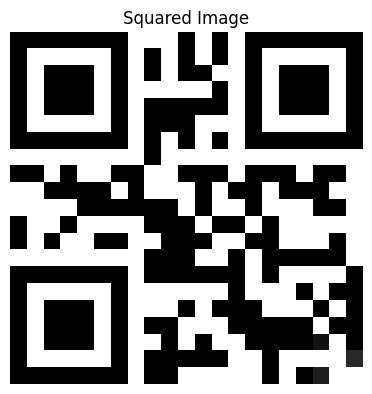

Final Image size: (21, 21)


In [24]:
def Banana(images, index=13):
    # Load the image
    img = images[index]

    # Check if the image was loaded successfully
    if img is not None:
        # Define the rotation angle in degrees
        angle = -20.5
        center = (img.shape[1] // 2, img.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

        # Define the crop boundaries
        top_crop = 585
        bottom_crop = 287
        left_crop = 550
        right_crop = rotated_img.shape[1]

        cropped_img = rotated_img[top_crop:rotated_img.shape[0] - bottom_crop, left_crop:right_crop]
        additional_right_crop = 325
        additional_cropped_img = cropped_img[:, :cropped_img.shape[1] - additional_right_crop]

        # Apply thresholding
        _, bw_img = cv2.threshold(additional_cropped_img, 90, 255, cv2.THRESH_BINARY)

        # Make the image square
        height, width = bw_img.shape
        if width > height:
            pad_top = (width - height) // 2
            pad_bottom = width - height - pad_top
            squared_img = np.pad(bw_img, ((pad_top, pad_bottom), (0, 0)), mode='constant', constant_values=255)
        else:
            pad_left = (height - width) // 2
            pad_right = height - width - pad_left
            squared_img = np.pad(bw_img, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=255)

        squared_img = cv2.resize(squared_img, (21, 21), cv2.INTER_NEAREST_EXACT)

        def modify_qr_code_bits(img):
            bottom_bits = img[-5:, 8]
            # Reverse the bits so the last bit in the column becomes the first bit in the row
            bottom_bits_reversed = bottom_bits[::-1]
            # Paste the reversed bits horizontally into the 9th row, from left to right in the first 5 columns
            img[8, 0:5] = bottom_bits_reversed
            return img

        img = modify_qr_code_bits(squared_img)

        # Show the squared image
        display_image(img, title='Squared Image')

        # Display final image size
        print("Final Image size:", squared_img.shape)
    else:
        print("Error: Unable to load image.")




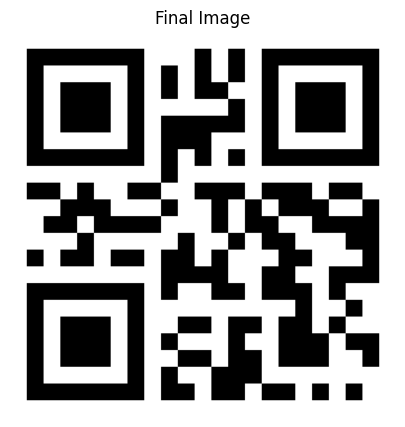

Final Image shape: (1012, 1012)


In [54]:
# def detect_finger(image):
#     # Convert image to HSV color space
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#     # Define lower and upper bounds for finger color in HSV
#     lower_finger = np.array([0, 1, 0], dtype=np.uint8)
#     upper_finger = np.array([255, 255, 255], dtype=np.uint8)

#     # Threshold the HSV image to get a binary mask of the finger region
#     finger_mask = cv2.inRange(hsv, lower_finger, upper_finger)

#     # Optional: Apply morphology operations to refine the mask (e.g., remove noise)
#     kernel = np.ones((9, 9), np.uint8)
#     finger_mask = cv2.morphologyEx(finger_mask, cv2.MORPH_OPEN, kernel)
#     finger_mask = cv2.morphologyEx(finger_mask, cv2.MORPH_CLOSE, kernel)

#     return finger_mask

def mirror_qr_marker(img):
    marker_size = 7
    # Coordinates for the bottom-left marker
    bottom_left_x = 0
    bottom_left_y = img.shape[0] - marker_size

    # Extract the bottom-left marker
    bottom_left_marker = img[bottom_left_y:bottom_left_y + marker_size,
                             bottom_left_x:bottom_left_x + marker_size]

    # Flip the marker horizontally to create a mirror effect
    mirrored_marker = cv2.flip(bottom_left_marker, 0)

    # Coordinates for the top-left marker replacement
    top_left_x = 0
    top_left_y = 0

    # Replace the top-left region with the mirrored marker
    img[top_left_y:top_left_y + marker_size,
        top_left_x:top_left_x + marker_size] = mirrored_marker

    return img

def Finger(images, index=6):
    img = images[index]

    # # Detect the finger region
    # finger_mask = detect_finger(img)

    # # Inpainting
    # inpainted_image = cv2.inpaint(img, finger_mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)

    # # Convert to grayscale and apply binary threshold
    # erosion_kernel = np.ones((9, 9), np.uint8)
    # _, thresholded_image = cv2.threshold(inpainted_image, 150, 255, cv2.THRESH_BINARY)

    # # Call the function to mirror and replace the markers
    # fixed_qr_image = mirror_qr_marker(thresholded_image)

    img=images[6]
# Function to detect the finger region
# def detect_finger(image):
#     # Convert image to HSV color space
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#     # Define lower and upper bounds for finger color in HSV
#     lower_finger = np.array([0, 1, 0], dtype=np.uint8)
#     upper_finger = np.array([255, 255, 255], dtype=np.uint8)

#     # Threshold the HSV image to get a binary mask of the finger region
#     finger_mask = cv2.inRange(hsv, lower_finger, upper_finger)

#     # Optional: Apply morphology operations to refine the mask (e.g., remove noise)
#     kernel = np.ones((9, 9), np.uint8)
#     finger_mask = cv2.morphologyEx(finger_mask, cv2.MORPH_OPEN, kernel)
#     finger_mask = cv2.morphologyEx(finger_mask, cv2.MORPH_CLOSE, kernel)

#     return finger_mask

def mirror_qr_marker(img):

    marker_size=7
    # Coordinates for the bottom-left marker
    bottom_left_x = 0
    bottom_left_y = img.shape[0] - marker_size

    # Extract the bottom-left marker
    bottom_left_marker = img[bottom_left_y:bottom_left_y + marker_size,
                             bottom_left_x:bottom_left_x + marker_size]

    # Flip the marker horizontally to create a mirror effect
    mirrored_marker = cv2.flip(bottom_left_marker, 0)

    # Coordinates for the top-left marker replacement
    top_left_x = 0
    top_left_y = 0

    # Replace the top-left region with the mirrored marker
    img[top_left_y:top_left_y + marker_size,
        top_left_x:top_left_x + marker_size] = mirrored_marker

    return img

    # Load or process the original image to detect the finger
    # Assuming `img` is already loaded or is in the appropriate format


    # # Inpainting
    # inpainted_image = cv2.inpaint(img, finger_mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)

    # Convert to grayscale and apply binary threshold
    erosion_kernel = np.ones((9, 9), np.uint8)
    _, thresholded_image = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)


    # marker_size = 450 # Adjust this size based on the QR code

    # # Call the function to mirror and replace the markers
    fixed_qr_image = mirror_qr_marker(thresholded_image)
    erosion_kernel = np.ones((15, 15), np.uint8)
    eroded_img = cv2.erode(fixed_qr_image, erosion_kernel, iterations=1)
    # Apply average filter
    avg_filtered_img = cv2.blur(eroded_img, (5, 5))
    start_row = 55
    end_row = 958
    start_col = 55
    end_col = 958
    avg_filtered_img = thresholded_image[start_row:end_row, start_col:end_col]
    # Convert the resized ROI to binary black and white using thresholding
    _, binary_roi = cv2.threshold(avg_filtered_img, 140, 255, cv2.THRESH_BINARY)
    img= cv2.resize(binary_roi, (21, 21), cv2.INTER_NEAREST_EXACT)


    fixed_qr_image = mirror_qr_marker(img)


    # Display the final processed image
display_image(img, title='Final Image')

    # Optional: Print the shape of the final image
print("Final Image shape:", img.shape)




Image size: (1012, 1012)


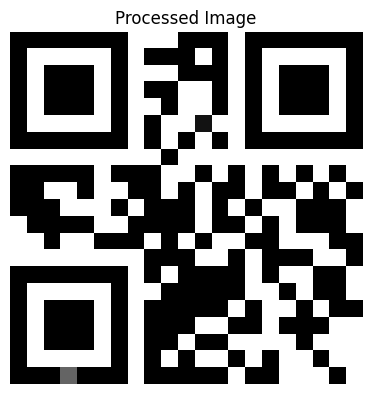

Final Image shape: (21, 21)


In [28]:
def salt(images, index=11):
    img = images[index]

    if img is not None:
        # Output the size of the image
        print("Image size:", img.shape)

        # Apply mean filter twice
        filtered_img = cv2.blur(img, (9, 9))
        filtered_img = cv2.blur(filtered_img, (9, 9))

        # Define the size of the larger filter
        filter_size = 9
        # Apply the larger filter to perform additional averaging
        filtered_img = cv2.blur(filtered_img, (filter_size, filter_size))

        # Apply thresholding to further remove noise or enhance edges
        _, thresh_img = cv2.threshold(filtered_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # Apply morphological opening to further refine the image
        kernel = np.ones((3, 3), np.uint8)
        opening_img = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)

        # Define the size of the square for dilation
        square_size = 12

        # Define the kernel for dilation
        dilation_kernel = np.ones((square_size, square_size), np.uint8)

        # Apply morphological dilation to make the black squares more square-shaped
        dilated_img = cv2.dilate(opening_img, dilation_kernel, iterations=1)

        # Apply erosion with a 15x15 pixel square filter
        erosion_kernel = np.ones((15, 15), np.uint8)
        eroded_img = cv2.erode(dilated_img, erosion_kernel, iterations=1)

        # Apply average filter
        avg_filtered_img = cv2.blur(eroded_img, (5, 5))

        # Define cropping dimensions
        start_row = 50
        end_row = 962
        start_col = 50
        end_col = 962
        cropped_img = avg_filtered_img[start_row:end_row, start_col:end_col]

        # Convert the resized ROI to binary black and white using thresholding
        _, binary_roi = cv2.threshold(cropped_img, 145, 255, cv2.THRESH_BINARY)

        # Resize the image
        resized_img = cv2.resize(binary_roi, (21, 21), cv2.INTER_NEAREST_EXACT)

        # Display the resulting image
        display_image(resized_img, title='Processed Image')

        # Optional: Print the shape of the final image
        print("Final Image shape:", resized_img.shape)
    else:
        print("Error: Unable to load image.")



Image loaded successfully.


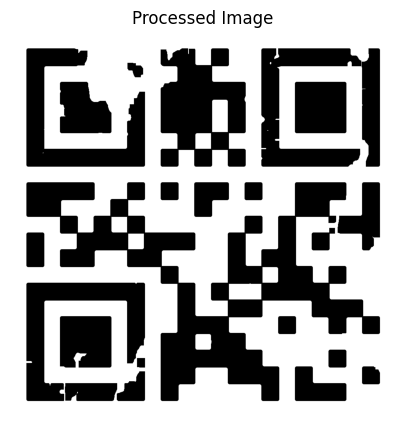

Final Image shape: (1012, 1012)


In [29]:


def Compresso(images, index=7):
    img = images[index]

    if img is None:
        print("Error: Unable to read images.")
    else:
        print("Image loaded successfully.")

        # Check the image data type
        if img.dtype != np.uint8:
            # Convert the image to 8-bit grayscale
            img = cv2.convertScaleAbs(img)

        # Equalize the histogram of the image
        equalized_image = cv2.equalizeHist(img)

        # Apply binary thresholding
        threshold_value = 254
        binary_image = np.array(cv2.threshold(equalized_image, threshold_value, 255, cv2.THRESH_BINARY)[1], dtype="uint8")

        # Apply median filtering with a kernel size of 7x7 (you can adjust the kernel size)
        kernel_size = 7
        median_filtered = cv2.medianBlur(binary_image, kernel_size)

        # Optional: Apply morphological operations (e.g., closing) to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        closed_image = cv2.morphologyEx(median_filtered, cv2.MORPH_CLOSE, kernel)

        # Define the size of the square for dilation
        square_size = 12

        # Define the kernel for dilation
        dilation_kernel = np.ones((square_size, square_size), np.uint8)

        # Apply morphological dilation to make the black squares more square-shaped
        dilated_img = cv2.dilate(closed_image, dilation_kernel, iterations=1)

        # Apply erosion with a 15x15 pixel square filter
        erosion_kernel = np.ones((15, 15), np.uint8)
        eroded_img = cv2.erode(dilated_img, erosion_kernel, iterations=1)

        # Display the resulting image
        display_image(eroded_img, title='Processed Image')

        # Optional: Print the shape of the final image
        print("Final Image shape:", eroded_img.shape)


# Process and display the image with histogram equalization at index 7
process_image_with_hist_equalization(images, 7)


Image size: (1012, 1012)


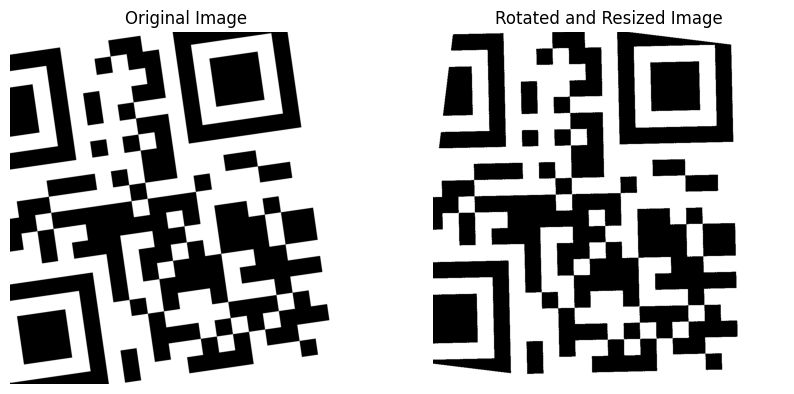

Final Image shape: (1012, 1012)


In [35]:
def rotated(images, index=1, angle=7 ):
    image = images[index]

    if image is not None:
        # Output the size of the image
        print("Image size:", image.shape)

        # Get the center of the image
        center = (image.shape[1] // 2, image.shape[0] // 2)

        # Perform the rotation
        rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), borderValue=(255, 255, 255))


        _, resized_binary = cv2.threshold(rotated_image, 128, 255, cv2.THRESH_BINARY)

        # Convert images to RGB for Matplotlib
        original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_rotated_rgb = cv2.cvtColor(resized_binary, cv2.COLOR_GRAY2RGB)

        # Display the original and resized rotated images
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(original_rgb)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(resized_rotated_rgb)
        plt.title('Rotated and Resized Image')
        plt.axis('off')

        plt.show()

        # Optional: Print the shape of the final image
        print("Final Image shape:", resized_binary.shape)
    else:
        print("Error: Unable to load image.")




In [ ]:
# img=images[0]

def find_non_white_bounds(image):
    def find_bounds(data, reverse=False):
        for idx, line in enumerate(data if not reverse else data[::-1]):
            if np.any(line != 255):  # Assuming white is the quiet zone color
                return len(data) - idx if reverse else idx
        return -1
    # Find row bounds
    start_row = find_bounds(image)
    end_row = find_bounds(image, reverse=True)
    # Find column bounds
    transposed = cv2.transpose(image)
    start_col = find_bounds(transposed)
    end_col = find_bounds(transposed, reverse=True)
    return start_row, end_row, start_col, end_col



def estimate_module_size(image):
    # Analyze specifically the top-left finder pattern
    height, width = image.shape
    finder_pattern_area = image[:height//5, :width//5]  # Roughly the top-left corner

    transitions = []
    for line in finder_pattern_area:
        # Detect changes from white to black and vice versa
        line_transitions = np.where(np.diff(line) != 0)[0]
        if line_transitions.size > 0:
            transitions.extend(np.diff(line_transitions))  # Distances between transitions

    if transitions:
        estimated_module_size = np.median(transitions)  # Median transition distance
        return max(1, int(estimated_module_size))  # Ensure at least 1
    return 1  # Fallback if no transitions found



def analyze_qr_structure(image):
    start_row, end_row, start_col, end_col = find_non_white_bounds(image)
    qr_no_quiet_zone = image[start_row:end_row, start_col:end_col]
    qr_no_quiet_zone = cv2.resize(qr_no_quiet_zone, (21, 21), cv2.INTER_NEAREST_EXACT)
    # qr_no_quiet_zone = mirror_qr_marker(qr_no_quiet_zone)
    # qr_no_quiet_zone=modify_qr_code_bits(qr_no_quiet_zone)

    module_size = estimate_module_size(qr_no_quiet_zone)
    if module_size <= 0:
        print("Module size computed as zero or negative, which is not feasible.")
        return

    # Calculate grid size ensuring divisibility by 21
    height, width = qr_no_quiet_zone.shape
    grid_cells_num = min(height, width) // module_size
    grid_cells_num = (grid_cells_num // 21) * 21  # Round down to the nearest multiple of 21

    # Ensure the cropped image dimensions are divisible by 21 and module_size
    qr_no_quiet_zone = qr_no_quiet_zone[:grid_cells_num * module_size, :grid_cells_num * module_size]

    # Reshape the image to visualize individual QR code cells
    qr_cells = qr_no_quiet_zone.reshape(
        (grid_cells_num, module_size, grid_cells_num, module_size)
    ).swapaxes(1, 2)


    # Set up the figure for displaying each grid cell
    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(8, 8))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
            col.axis('off')  # Hide both axes
            col.spines[:].set_color('red')
            col.spines[:].set_linewidth(40)

    plt.show()


    MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
    }

    # Initialize a binary grid to represent the QR code cells
    qr_cells_numeric = np.zeros((grid_cells_num, grid_cells_num), dtype=np.uint8)

    # Fill the grid with binary values based on median brightness
    for i in range(grid_cells_num):
        for j in range(grid_cells_num):
            cell = qr_cells[i, j]
            qr_cells_numeric[i, j] = 1 if np.median(cell) > 127 else 0

    # # Extract FEC (Format Information Code)
    fec = []
    fec.append(qr_cells_numeric[8, 5])
    fec.append(qr_cells_numeric[8, 7])
    fec.extend(qr_cells_numeric[0:6, 8])
    fec.extend(qr_cells_numeric[7:9, 8])
    fec = [int(not c) for c in fec]



    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
    for i, row in enumerate(axes):
      for j, col in enumerate(row):
          col.get_xaxis().set_visible(False)
          col.get_yaxis().set_visible(False)

          # Highlight the finder patterns (excluding alignment pattern)
          if (i == 8 and j <= 8) or (i <= 8 and j == 8):
              if (i != 6) and (j != 6):
                  col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                  for spine in col.spines.values():
                      spine.set_edgecolor('red')
                  continue

          col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)


    UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)  # A rather old-fas       hioned pythonic "Enum"
    def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
      result = []
      row_offsets = []
      col_offsets = []

      # Convert mask from list of ints to a string key for dictionary access
      mask_str = ''.join(str(bit) for bit in mask)  # Ensuring mask is a string

      if direction in [0, 1]:  # UP8, UP4
          row_offsets = [0, 0, -1, -1, -2, -2, -3, -3]
          col_offsets = [0, -1, 0, -1, 0, -1, 0, -1]
      elif direction in [2, 3]:  # DOWN8, DOWN4
          row_offsets = [0, 0, 1, 1, 2, 2, 3, 3]
          col_offsets = [0, -1, 0, -1, 0, -1, 0, -1]
      elif direction == 4:  # CW8
          row_offsets = [0, 0, 1, 1, 1, 1, 0, 0]
          col_offsets = [0, -1, 0, -1, -2, -3, -2, -3]
      elif direction == 5:  # CCW8
          row_offsets = [0, 0, -1, -1, -1, -1, 0, 0]
          col_offsets = [0, -1, 0, -1, -2, -3, -2, -3]

      for i, j in zip(row_offsets, col_offsets):
          cell_bit = bool(data[data_start_i+i, data_start_j+j])
          mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)  # Using the string key
          result.append(int(not cell_bit if mask_bit else cell_bit))
      return result[:4] if direction in [1, 3] else result



    grid_cells_num_inv = 1 - qr_cells_numeric




    # # Primary extraction from the top
    ecl = grid_cells_num_inv[8, 0:2]
    mask = grid_cells_num_inv[8, 2:5]
    mask_str = ''.join([str(m) for m in mask])

    # Apply masks to retrieve encoding and length bits
    enc_bits = apply_mask_general(20, 20, grid_cells_num_inv, mask_str, 1)  # UP4
    len_bits = apply_mask_general(21 - 3, 21 - 1, grid_cells_num_inv, mask_str, 0)  # UP8
    # Convert binary bits to integers
    len_int = int(''.join([str(bit) for bit in len_bits]), 2)

    # ecl = grid_cells_num_inv[20:18:-1, 8]  # Extracts in reverse from 21st row to 16th
    # mask = grid_cells_num_inv[18:15:-1, 8]  # Adjusted index for bottom extraction
    # mask_str = ''.join([str(m) for m in mask])

    # enc_bits = apply_mask_general(21-1, 21 - 1, grid_cells_num_inv, mask_str, 1)  # UP4 adjusted for bottom
    # len_bits = apply_mask_general(21-3, 21 - 1, grid_cells_num_inv, mask_str, 0)  # UP8 adjusted for bottom
    # # Convert binary bits to integers
    # len_int = int(''.join([str(bit) for bit in len_bits]), 2)



    # Display the extracted information
    print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

    block_starting_indices = [
      [21-7,  21-1,  UP8],
      [21-11, 21-1,  CCW8],
      [21-10, 21-3,  DOWN8],
      [21-6,  21-3,  DOWN8],
      [21-2,  21-3,  CW8],
      [21-3,  21-5,  UP8],
      [21-7,  21-5,  UP8],
      [21-11, 21-5,  CCW8],
      [21-10, 21-7,  DOWN8],
      [21-6,  21-7,  DOWN8],
      [21-2,  21-7,  CW8],
      [21-3,  21-9,  UP8],
      [21-7,  21-9,  UP8],
      [21-11, 21-9,  UP8],
      [21-16, 21-9,  UP8],
      [21-20, 21-9,  CCW8],
      [21-19, 21-11, DOWN8],
      [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
      [21-12, 21-11, DOWN8],
      [21-8,  21-11, DOWN8],
      [21-4,  21-11, DOWN8],
      [21-9,  21-13, UP8],
      [21-12, 21-16, DOWN8],
      [21-9,  21-18, UP8],
      [21-12, 21-20, DOWN8],
  ]
    # Initialize an empty list to store the message bits
    message_bits = []
    message_bits.extend(enc_bits)
    message_bits.extend(len_bits)
    def extract_message_bits(grid_cells_num_inv, block_starting_indices, mask, len_int):
        # Read the data bytes, starting from the very first byte after enc and len
        byte_index = 0
        # First loop to handle message bytes
        for _ in range(len_int):
            if byte_index < len(block_starting_indices):
                start_i, start_j, dir = block_starting_indices[byte_index]
                bits = apply_mask_general(start_i, start_j, grid_cells_num_inv, mask, dir)
                message_bits.extend(bits)
                bit_string = ''.join([str(bit) for bit in bits])
                alpha_char = chr(int(bit_string, 2))
                print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
                byte_index += 1
            else:
                print(f"Warning: byte_index ({byte_index}) exceeds block starting indices (length: {len(block_starting_indices)})")
                break
        return message_bits, byte_index

    def read_additional_data(block_starting_indices, message_bits, grid_cells_num_inv, mask, byte_index):
        if byte_index < len(block_starting_indices):
            start_i, start_j, dir = block_starting_indices[byte_index]
            bits = apply_mask_general(start_i, start_j, grid_cells_num_inv, mask, dir)
            message_bits.extend(bits)
            bit_string = ''.join([str(bit) for bit in bits])
            print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
            byte_index += 1
        else:
            print(f"Warning: byte_index ({byte_index}) exceeds block starting indices (length: {len(block_starting_indices)})")
        # Remaining loop for extra bytes (25-len-1)
        for _ in range(25 - len_int - 1):
            if byte_index < len(block_starting_indices):
                start_i, start_j, dir = block_starting_indices[byte_index]
                bits = apply_mask_general(start_i, start_j, grid_cells_num_inv, mask, dir)
                message_bits.extend(bits)
                bit_string = ''.join([str(bit) for bit in bits])
                alpha_char = chr(int(bit_string, 2))
                print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
                byte_index += 1
            else:
                print(f"Warning: byte_index ({byte_index}) exceeds block starting indices (length: {len(block_starting_indices)})")
                break

        return message_bits, byte_index

    message_bits, byte_index = extract_message_bits(grid_cells_num_inv, block_starting_indices, mask, len_int)
    message_bits ,byte_index= read_additional_data(block_starting_indices, message_bits, grid_cells_num_inv, mask, byte_index)


      # For every 8 bits in the extracted message, convert to a byte
    message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

    # Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
    rsc = rs.RSCodec(nsym=7)

    # Decode the bytes with the 7-ECC RS Codec
    message_decoded = rsc.decode(message_bytes)
    rsc.maxerrata(verbose=True)

    # In order to extract the actual data, need to convert back to bits
    # Then take as many bytes as indicated by the message length indicator
    # That is AFTER removing the first 12 bytes (of enc and len)
    data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]
    # data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[2:2+len_int*8]


    # Now convert back to bytes and print it lol
    data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
    print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')

